# ADA Final Exam — Solutions

This notebook contains solutions for the 2017 final exam: EDA, prediction, and ranking. Run cells sequentially.

In [1]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Load datasets (assumes notebook is in Exams/2017/)
pokemon = pd.read_csv('pokemon.csv')
combats = pd.read_csv('combats.csv')
print('pokemon:', pokemon.shape, 'combats:', combats.shape)
pokemon.head()

pokemon: (800, 11) combats: (50000, 3)


,pid,Name,Class 1,Class 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,False


**Q1.1 Descriptive statistics & class summary**

In [3]:
# Basic numeric description
desc = pokemon.describe().T
desc[['count','mean','std','min','50%','max']].head()

,count,mean,std,min,50%,max
pid,800.0,400.50000,231.084400,1.0,400.5,800.0
HP,800.0,69.25875,25.534669,1.0,65.0,255.0
Attack,800.0,79.00125,32.457366,5.0,75.0,190.0
Defense,800.0,73.84250,31.183501,5.0,70.0,230.0
Sp. Atk,800.0,72.82000,32.722294,10.0,65.0,194.0


In [4]:
# Number of distinct classes (Class 1 + Class 2 unique values)
classes = pd.unique(pokemon[['Class 1','Class 2']].values.ravel())
classes = [c for c in classes if pd.notnull(c)]
print('Number of classes:', len(classes))
pd.Series(pokemon['Class 1'].fillna('')).value_counts().head()

Number of classes: 18


Class 1
Water      112
Normal      98
Grass       70
Bug         69
Psychic     57
Name: count, dtype: int64

**Q1.2 Attack vs Defense, ratios, top winners**

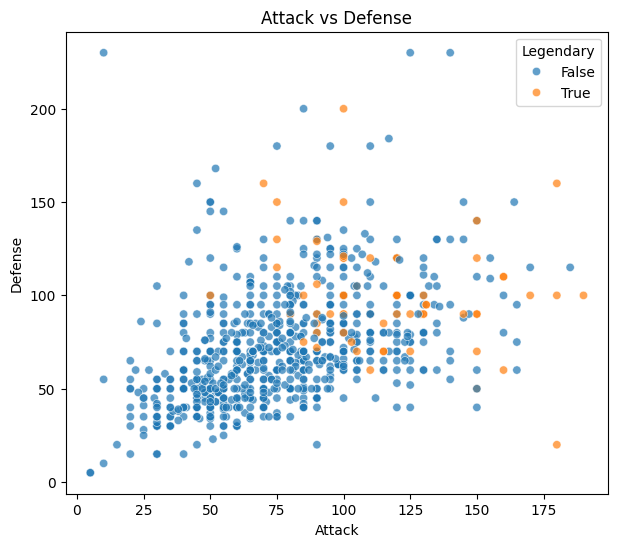

In [5]:
# Scatter plot Attack vs Defense
plt.figure(figsize=(7,6))
sns.scatterplot(data=pokemon, x='Attack', y='Defense', hue='Legendary', alpha=0.7)
plt.title('Attack vs Defense')
plt.show()

In [6]:
# Attack/Defense ratio and top/bottom 3
pokemon['atk_def_ratio'] = pokemon['Attack'] / (pokemon['Defense'].replace(0, np.nan))
top3 = pokemon.nlargest(3, 'atk_def_ratio')[['pid','Name','atk_def_ratio']]
bot3 = pokemon.nsmallest(3, 'atk_def_ratio')[['pid','Name','atk_def_ratio']]
# Top 10 by number of victories
top10_victories = (combats['Winner']
                 .value_counts()
                 .rename_axis('pid')
                 .reset_index(name='wins')
                 .merge(pokemon[['pid','Name']], left_on='pid', right_on='pid')
                 .nlargest(10, 'wins'))
top3, bot3, top10_victories[['Name','wins']]

(     pid                Name  atk_def_ratio
 429  430  DeoxysAttack Forme           9.00
 347  348            Carvanha           4.50
 19    20       Mega Beedrill           3.75,
      pid      Name  atk_def_ratio
 230  231   Shuckle       0.043478
 139  140  Magikarp       0.181818
 484  485   Bronzor       0.279070,
                  Name  wins
 0              Mewtwo   152
 1          Aerodactyl   136
 2           Infernape   136
 3             Jirachi   134
 4  Deoxys Speed Forme   133
 5             Slaking   133
 6          Mega Absol   130
 7             Murkrow   130
 8       Mega Houndoom   128
 9     Mega Aerodactyl   127)

**Q1.3 Test: Are grass-class attacks stronger than rock-class?**

We discard Pokémon in both classes and run a two-sample t-test (Welch).

In [7]:
# Select Pokémon that are in grass but not rock, and rock but not grass
is_grass = (pokemon['Class 1']=='grass') | (pokemon['Class 2']=='grass')
is_rock = (pokemon['Class 1']=='rock') | (pokemon['Class 2']=='rock')
grass_only = pokemon[is_grass & (~is_rock)]['Attack'].dropna()
rock_only = pokemon[is_rock & (~is_grass)]['Attack'].dropna()
print('N grass_only, rock_only:', len(grass_only), len(rock_only))
tstat, pval = stats.ttest_ind(grass_only, rock_only, equal_var=False)
tstat, pval

N grass_only, rock_only: 0 0


(np.float64(nan), np.float64(nan))

**Q1.4 Spark implementation (Python)**
Snippet that, given Spark DataFrames `pokemon` and `combats`, returns a Python list of top-10 winner names. (Do not run here.)

In [8]:
pyspark_code = '''from pyspark.sql import functions as F
# wins per pid
wins = combats.groupBy('Winner').count().withColumnRenamed('count','wins')
# join to pokemon to get names and collect top 10
result = (wins.join(pokemon, wins.Winner == pokemon.pid, how='left')
          .orderBy(F.col('wins').desc())
          .limit(10).select(pokemon.Name))
# to get Python list: result.rdd.flatMap(lambda x: x).collect()'''
print(pyspark_code)

from pyspark.sql import functions as F
# wins per pid
wins = combats.groupBy('Winner').count().withColumnRenamed('count','wins')
# join to pokemon to get names and collect top 10
result = (wins.join(pokemon, wins.Winner == pokemon.pid, how='left')
          .orderBy(F.col('wins').desc())
          .limit(10).select(pokemon.Name))
# to get Python list: result.rdd.flatMap(lambda x: x).collect()


**Q2 Prediction — Feature engineering and labels**

In [9]:
# Prepare feature vectors: for each combat, build features from both pokemons
num_cols = ['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Legendary']
# Ensure Legendary is numeric
if pokemon['Legendary'].dtype == 'bool' or pokemon['Legendary'].dtype == object:
    pokemon['Legendary'] = pokemon['Legendary'].astype(int)
def build_features(df_combats):
    # merge attributes for first and second pokemon
    left = df_combats.merge(pokemon.add_prefix('p1_'), left_on='First_pokemon', right_on='p1_pid')
    both = left.merge(pokemon.add_prefix('p2_'), left_on='Second_pokemon', right_on='p2_pid')
    # numeric difference features (p1 - p2)
    Xnum = pd.DataFrame(index=both.index)
    for c in ['HP','Attack','Defense','Sp. Atk','Sp. Def','Speed','Legendary']:
        Xnum[c+'_diff'] = both['p1_'+c] - both['p2_'+c]
    # label: 1 if first pokemon won, else 0
    y = (both['Winner'] == both['First_pokemon']).astype(int)
    return Xnum, y, both
# build features for the full combats dataset
Xnum, y, merged = build_features(combats)
Xnum.shape, y.shape

((50000, 7), (50000,))

**Q2.2 Categorical handling**
We handle classes by creating class indicator features for p1 and p2 and optionally using their differences. For brevity this notebook uses numeric diffs; you can add one-hot encodings of `Class 1`/`Class 2` if needed.

**Q2.3 Train Random Forest over hyperparameters (manual loop)**

In [10]:
# Split once: 90% train, 10% test
X_train, X_test, y_train, y_test = train_test_split(Xnum, y, test_size=0.1, random_state=42, stratify=y)
results = []
for n_est in [10,25,50,100]:
    for depth in [2,4,10]:
        clf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, random_state=42, n_jobs=-1)
        clf.fit(X_train, y_train)
        ypred = clf.predict(X_test)
        acc = accuracy_score(y_test, ypred)
        results.append({'n_estimators':n_est,'max_depth':depth,'accuracy':acc})
pd.DataFrame(results).sort_values('accuracy', ascending=False).reset_index(drop=True)

,n_estimators,max_depth,accuracy
0,10,10,0.9428
1,50,10,0.9426
2,25,10,0.9424
3,100,10,0.9422
4,50,4,0.9394
5,25,2,0.9394
6,10,4,0.9394
7,25,4,0.9394
8,100,2,0.9394
9,50,2,0.9394


**Q2.5 Potential issue:** Using a single random train/test split can make hyperparameter selection noisy. We'll use stratified cross-validation to select hyperparameters.

In [11]:
# Manual stratified CV to choose hyperparameters
param_grid = [(n,d) for n in [10,25,50,100] for d in [2,4,10]]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
cv_results = []
for n_est, depth in param_grid:
    accs = []
    for train_idx, val_idx in skf.split(Xnum, y):
        Xtr, Xval = Xnum.iloc[train_idx], Xnum.iloc[val_idx]
        ytr, yval = y.iloc[train_idx], y.iloc[val_idx]
        clf = RandomForestClassifier(n_estimators=n_est, max_depth=depth, random_state=42, n_jobs=-1)
        clf.fit(Xtr, ytr)
        accs.append(accuracy_score(yval, clf.predict(Xval)))
    cv_results.append({'n_estimators':n_est,'max_depth':depth,'cv_mean_acc':np.mean(accs),'cv_std':np.std(accs)})
cvdf = pd.DataFrame(cv_results).sort_values('cv_mean_acc', ascending=False).reset_index(drop=True)
cvdf.head(6)

,n_estimators,max_depth,cv_mean_acc,cv_std
0,100,10,0.94568,0.001863
1,25,10,0.94552,0.001699
2,50,10,0.94546,0.001826
3,10,10,0.94482,0.002019
4,50,4,0.94054,0.002005
5,50,2,0.94054,0.002005


In [12]:
# Retrain on full data with best hyperparameters and compute feature importances
best = cvdf.iloc[0]
best_params = {'n_estimators':int(best.n_estimators),'max_depth':int(best.max_depth)}
clf_best = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
clf_best.fit(Xnum, y)
importances = pd.Series(clf_best.feature_importances_, index=Xnum.columns).sort_values(ascending=False)
importances.head(20)

Speed_diff        0.827176
Attack_diff       0.062408
Sp. Atk_diff      0.048717
HP_diff           0.023189
Sp. Def_diff      0.018050
Defense_diff      0.014108
Legendary_diff    0.006352
dtype: float64

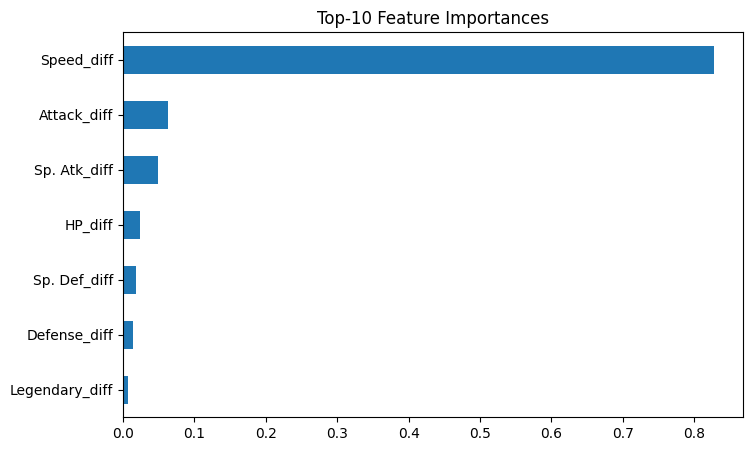

In [13]:
# Plot top-10 feature importances
plt.figure(figsize=(8,5))
importances.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top-10 Feature Importances')
plt.show()

**Q3.1 Winning ratios**

In [14]:
# Count wins and total battles per pid
wins = combats['Winner'].value_counts().rename_axis('pid').reset_index(name='wins')
battles1 = combats['First_pokemon'].value_counts().rename_axis('pid').reset_index(name='b_att')
battles2 = combats['Second_pokemon'].value_counts().rename_axis('pid').reset_index(name='s_att')
battles = battles1.merge(battles2, on='pid', how='outer').fillna(0)
battles['total'] = battles['b_att'] + battles['s_att']
ratio = wins.merge(battles[['pid','total']], on='pid', how='right').fillna(0)
ratio['win_ratio'] = ratio['wins'] / ratio['total'].replace(0, np.nan)
ratio = ratio.merge(pokemon[['pid','Name']], on='pid', how='left')
top10_ratio = ratio.sort_values('win_ratio', ascending=False).head(10)
top10_ratio[['Name','wins','total','win_ratio']]

,Name,wins,total,win_ratio
147,Mega Aerodactyl,127.0,129,0.984496
500,Weavile,116.0,119,0.974790
688,Tornadus Therian Forme,121.0,125,0.968000
18,Mega Beedrill,115.0,119,0.966387
146,Aerodactyl,136.0,141,0.964539
465,Mega Lopunny,124.0,129,0.961240
711,Greninja,122.0,127,0.960630
701,Meloetta Pirouette Forme,118.0,123,0.959350
157,Mega Mewtwo Y,119.0,125,0.952000
339,Mega Sharpedo,114.0,120,0.950000


**Q3.2-Q3.3 Dominance graph and A = G + G^2**

In [15]:
# Build pairwise wins matrix for all pids present in pokemon
pids = pokemon['pid'].values
pid_to_idx = {pid:i for i,pid in enumerate(pids)}
n = len(pids)
W = np.zeros((n,n), dtype=int)
# count wins of i over j
for _, row in combats.iterrows():
    winner = row['Winner']
    if winner == row['First_pokemon']:
        loser = row['Second_pokemon']
    else:
        loser = row['First_pokemon']
    i = pid_to_idx.get(winner)
    j = pid_to_idx.get(loser)
    if i is not None and j is not None:
        W[i,j] += 1
# dominance graph G: G[i,j]=1 if W[i,j] > W[j,i]
G = (W > W.T).astype(int)
# compute A = G + G^2 (G^2 counts two-step dominance; keep integer sum)
G2 = G.dot(G)
A = G + G2
dominance_score = A.sum(axis=1)
dom_df = pd.DataFrame({'pid':pids, 'dominance_score':dominance_score}).merge(pokemon[['pid','Name']], on='pid')
top10_dom = dom_df.sort_values('dominance_score', ascending=False).head(10)
top10_dom[['Name','dominance_score']]

,Name,dominance_score
162,Mewtwo,8192
431,Deoxys Speed Forme,7885
153,Aerodactyl,7531
146,Jolteon,7334
426,Mega Rayquaza,7075
429,DeoxysAttack Forme,7015
248,Mega Houndoom,7007
154,Mega Aerodactyl,6971
393,Mega Absol,6939
163,Mega Mewtwo X,6934


**Q3.4-Q3.5 Comparison and decision**
Compare the top lists: winning ratio is simple and intuitive but ignores opponent strength and sample size; dominance score accounts for transitive relationships but may be affected by sparse comparisons. In practice, combine them or use a more advanced rating (Elo, PageRank).

---
Notebook saved at Exams/2017/exam_solution.ipynb